## Test Add Channel

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
from getSIDMdata_generator_meta import get_tf_DataSet as getGenerators
import scienceplots
plt.style.use(["science", "grid"])

Objectives
----------
1. To see if adding channels increases the accuracy of the model
2. To see if adding correlation functions between models increases the accuracy of the model

Conclusions
-----------



In [ ]:
simulationNames = ['CDM','SIDM0.1','SIDM1']
nClasses = len(simulationNames)
epochs=80

#### 1. Get the fiducial (total only)

In [ ]:
fiducial_train_ds, fiducial_test_ds  = getGenerators(augment_data=True, simulationNames=simulationNames, channels=['total'], 
                                                      allDataFile='pickles/binned_data_20.pkl')
total_only = simpleCNN.getModel_ds(nClasses)
history = total_only.fit(
  x=fiducial_train_ds,
  validation_data=fiducial_test_ds,
  epochs=epochs
)

#### 2. Add stellar channel and see what that does.

In [ ]:
fiducial_train_ds, fiducial_test_ds  = getGenerators(augment_data=True, simulationNames=simulationNames, channels=['total','stellar'], 
                                                      allDataFile='pickles/binned_data_20.pkl')
tot_stellar = simpleCNN.getModel_ds(nClasses)
history = tot_stellar.fit(
  x=fiducial_train_ds,
  validation_data=fiducial_test_ds,
  epochs=epochs
)

#### 3. Add xray channel and see what that does.

In [ ]:
fiducial_train_ds, fiducial_test_ds  = getGenerators(augment_data=True, simulationNames=simulationNames, channels=['total','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl')
tot_xray = simpleCNN.getModel_ds(nClasses)
history = tot_xray.fit(
  x=fiducial_train_ds,
  validation_data=fiducial_test_ds,
  epochs=epochs
)

#### 4. xray and stellar channel and see what that does.

In [ ]:
fiducial_train_ds, fiducial_test_ds  = getGenerators(augment_data=True, simulationNames=simulationNames, channels=['stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl')
stel_xr = simpleCNN.getModel_ds(nClasses)
history = stel_xr.fit(
  x=fiducial_train_ds,
  validation_data=fiducial_test_ds,
  epochs=epochs
)

#### 5. Add all

In [ ]:
fiducial_train_ds, fiducial_test_ds  = getGenerators(augment_data=True, simulationNames=simulationNames, channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl')
all_channels = simpleCNN.getModel_ds(nClasses)
history = all_channels.fit(
  x=fiducial_train_ds,
  validation_data=fiducial_test_ds,
  epochs=epochs
)

#### 5. Add correlation functions

In [ ]:
train_ds, test_ds = get_tf_DataSet( augment_data=True, correlations=[['total','stellar']], 
                                  simulationNames=['CDM','SIDM1'])

In [ ]:
epochs=20
correlation_model = simpleCNN.getModel_ds(train_ds.num_classes)

cor_history = correlation_model.fit(
  x=train_ds,
    validation_data=test_ds,
  epochs=epochs
)


#### 6. Add correlation functions and stellar

In [ ]:
train_ds, test_ds = get_tf_DataSet( augment_data=True, channels=['total','stellar'], 
                                   correlations=[['total','stellar']],simulationNames=['CDM','SIDM1'])

In [ ]:
epochs=20
correlation_model_w_stellar = simpleCNN.getModel_ds(train_ds.num_classes)

cor_w_stel_history = correlation_model_w_stellar.fit(
  x=train_ds,
    validation_data=test_ds,
  epochs=epochs
)

#### Results

In [18]:
models =[total_only, tot_stellar, tot_xray, stel_xr, all_channels ]
savethese = [ i.history.history for i in models ]
pkl.dump(savethese, open("pickles/add_channel_test_post_referee.pkl","wb"))

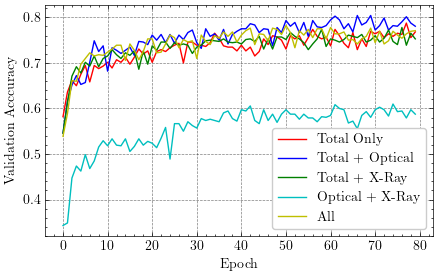

In [20]:
plt.figure(figsize=(5,3))
plt.xlabel('Epoch')
plt.ylabel('Validation Acccuracy')
models = pkl.load(open("pickles/add_channel_test_post_referee.pkl","rb"))

c = ['r','b','g','c','y','k']
names = ['Total Only','Total + Optical','Total + X-Ray','Optical + X-Ray','All','corr','corr+stellar']
for i, iModel in enumerate(models):
    plt.plot(np.arange(len(iModel['val_accuracy'])), iModel['val_accuracy'], label=names[i], c=c[i])
    #plt.plot(iModel.history.epoch, [np.max(iModel.history.history['val_accuracy'])]*len(iModel.history.epoch), c=c[i])
    #print(np.max(iModel.history.history['val_accuracy']))

plt.legend()
plt.savefig("../plots/input_channels.pdf")

### The old way i did it
Add channels simply with a multi layered input, however the memory blows up when augmented

So trying adding channels simply with a model per channel

In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=2)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        
nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]

color=['r','g','b','c']

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannelWithModel_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannelWithModel_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModelSeparateChannels( inputShape, nClasses, nAttributes=0, \
                               momentum=0.9, finalLayer=256, learning_rate=1e-4)
    
nChannels = train_images.shape[-1]
inputLayer = [ train_images[:,:,:,i][:,:,:,np.newaxis] for i in range(nChannels)]
testInputLayer = [ test_images[:,:,:,i][:,:,:,np.newaxis] for i in range(nChannels)]


history = model.fit(inputLayer, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(testInputLayer, test_labels),
                       callbacks=csv_logger)
model.save(model_file)



In [ ]:
train_images.shape

In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=2)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        
nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]


color=['r','g','b','c']

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannel_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannel_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModel( inputShape, nClasses, nAttributes=0, \
                               momentum=0.9, finalLayer=256, learning_rate=1e-4)
    
nChannels = train_images.shape[-1]


history = model.fit(train_images, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
model.save(model_file)



In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=3)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        


color=['r','g','b','c']

train_images[:, :, :, 1] =  train_images[:,:,:,2]
train_images = train_images[:, :, :, :2]


test_images[:, :, :, 1] =  test_images[:,:,:,2]
test_images = test_images[:, :, :, :2]

nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannelStellar_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannelStellar_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModel( inputShape, nClasses, nAttributes=0, \
                               momentum=0.9, finalLayer=256, learning_rate=1e-4)
    
nChannels = train_images.shape[-1]


history = model.fit(train_images, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
model.save(model_file)



In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=3)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        


color=['r','g','b','c']

nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannelAll_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannelAll_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModel( inputShape, nClasses, nAttributes=0, \
                               momentum=0.9, finalLayer=256, learning_rate=1e-4)
    
nChannels = train_images.shape[-1]


history = model.fit(train_images, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
model.save(model_file)



In [ ]:
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexes', testTrainSplit=0.15, nChannels=2)

test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        


color=['r','g','b','c']

nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]

#Test the momentum on reliability

csv_file = 'pickles/addAttributesAddChannelDepthWise_2_SGD.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/addAttributesAddChannelDepthWise_2_SGD.h5'
    
if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getDepthWiseConvolution( inputShape, nClasses, nAttributes=0, \
                              momentum=0.9, finalLayer=256, learning_rate=1e-4)
model.summary()

nChannels = train_images.shape[-1]


history = model.fit(train_images, train_labels, epochs=40, 
                    initial_epoch=0,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
model.save(model_file)

